<a href="https://colab.research.google.com/github/tomassams/tdt4173-machine-learning-project/blob/main/TDT4173_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TDT4173 Project Assignment: A comparison of KNN and CNN for image classification


This notebook contains the code used in the TDT4173 group project assignment at NTNU, fall 2020.

You can run these code cells on your own if you want. Note that some parts are resource and computation intensive.

It is recommended to run the CNN section on a computer with a GPU usage, or on a cloud provider that provides GPU (such as Google Colab).

**Be advised: the dataset contains pictures of e.g. diseases from inside the gastrointestinal tract, with everything that entails.**

## 1 Setup



### 1.1 Import libraries

If any of these imports return an error, you might have to install them with pip. It can be done in the command line, or by executing it in a notebook code cell.

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
import cv2
import pandas as pd
import numpy as np
from imutils import paths
import os
import imutils
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import datetime, os

In [ ]:
# Example on how to install pip packages inside a notebook, if above returns an error
!pip install pandas

In [16]:
# A helper utility to generate a pretty confusion matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.autoscale()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

### 1.2 Download the dataset
We are using the 'kvasir' dataset from Simula. They provide a direct link on their website, so let us download it directly into our workspace with wget before unzipping it.

In [1]:
!wget "https://datasets.simula.no/kvasir/data/kvasir-dataset-v2.zip"
!unzip -qq kvasir-dataset-v2.zip
!ls

--2020-11-08 17:11:10--  https://datasets.simula.no/kvasir/data/kvasir-dataset-v2.zip
Resolving datasets.simula.no (datasets.simula.no)... 128.39.36.14
Connecting to datasets.simula.no (datasets.simula.no)|128.39.36.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2489312085 (2.3G) [application/zip]
Saving to: ‘kvasir-dataset-v2.zip’

kvasir-dataset-v2.z 100%[===================>]   2.32G  8.69MB/s    in 3m 41s  

2020-11-08 17:14:52 (10.7 MB/s) - ‘kvasir-dataset-v2.zip’ saved [2489312085/2489312085]

kvasir-dataset-v2  kvasir-dataset-v2.zip  sample_data


## 2 K-Nearest Neighbor (KNN)

### 2.1 Preprocessing and feature extraction


In [5]:
# Collect all images into a list
img_paths = list(paths.list_images('kvasir-dataset-v2'))

# Print first 10 to see if they make sense
img_paths[:10]

['kvasir-dataset-v2/normal-z-line/30ad4e94-e694-439a-acbb-ab0d1c3922b9.jpg',
 'kvasir-dataset-v2/normal-z-line/d87678ae-47c4-4e2e-9288-caebb9471490.jpg',
 'kvasir-dataset-v2/normal-z-line/162338dc-41e6-49ee-a8cf-3d7b09baaafe.jpg',
 'kvasir-dataset-v2/normal-z-line/c1da34c4-89e8-4318-8525-0a5f83af40da.jpg',
 'kvasir-dataset-v2/normal-z-line/60b487ce-0101-461b-830a-e87ac7ea0f96.jpg',
 'kvasir-dataset-v2/normal-z-line/6b0f55b3-1ef2-46af-bb60-afbeeb45e9a0.jpg',
 'kvasir-dataset-v2/normal-z-line/d64a597d-38ed-4992-8e3f-8e14d2e38c80.jpg',
 'kvasir-dataset-v2/normal-z-line/c38ae957-4556-4993-b0e0-7e2cde4f62c1.jpg',
 'kvasir-dataset-v2/normal-z-line/5f8a0e10-e7fe-49fa-9e82-21a505392fd6.jpg',
 'kvasir-dataset-v2/normal-z-line/2e2447d1-29d0-4988-b9ca-16d4757e52f4.jpg']

In [8]:
def image_to_feature_vector(image, size=(32, 32)):
	"""
		Feature extraction
		Resize an image and flatten it into a list of raw pixels
	"""
	return cv2.resize(image, size).flatten()
 
def extract_color_histogram(image, bins=(8, 8, 8)):
	"""
		Feature extraction
		Extract a 3D color histogram in HSV color space
	"""
	hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
	hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,[0, 180, 0, 256, 0, 256])

	
	if imutils.is_cv2(): # special handling if OpenCV 2.4.X
		hist = cv2.normalize(hist)
	else:
		cv2.normalize(hist, hist)

	return hist.flatten()

In [9]:
def extract_dataset_features(img_paths, histogram_bins=(8,8,8), image_size=(32,32)):
	data_raw_pixels = []
	data_color_histogram = []
	data_labels = []

	# Go through all our image paths to extract features
	for (i, img_path) in enumerate(img_paths):

		# Extract image and label from path
		image = cv2.imread(img_path)
		label = img_path.split(os.path.sep)[-2].split(".")[0]

		# Extract raw pixel intensity features
		pixels = image_to_feature_vector(image, size=image_size)

		# Extract color histogram to characterize the color distribution of the pixels
		histogram = extract_color_histogram(image, bins=histogram_bins)

		# Update the raw images, features, and labels matricies respectively
		data_raw_pixels.append(pixels)
		data_color_histogram.append(histogram)
		data_labels.append(label)

		# Show an update every 1.000 images
		if i > 0 and i % 1000 == 0:
			print(f"processed {i}/{len(img_paths)}")

	print("Done processing")
 
	return (data_raw_pixels, data_color_histogram, data_labels)

data_raw_pixels, data_color_histogram, data_labels = extract_dataset_features(img_paths)

processed 1000/8000
processed 2000/8000
processed 3000/8000
processed 4000/8000
processed 5000/8000
processed 6000/8000
processed 7000/8000
Done processing


In [10]:
# retrieve unique labels and their indices to use later
unique_labels, unique_indices = np.unique(data_labels, return_index=True)

dyed-lifted-polyps


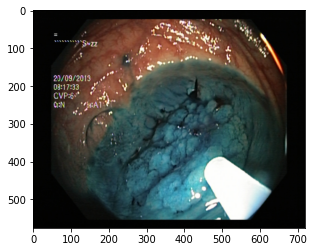

dyed-resection-margins


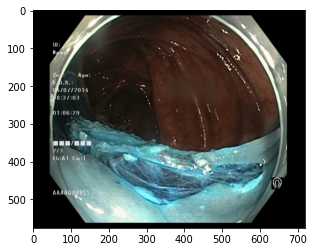

esophagitis


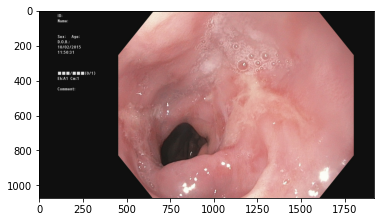

normal-cecum


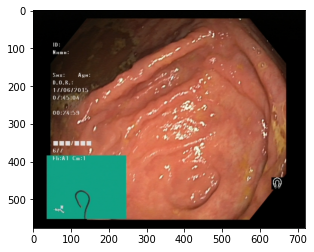

normal-pylorus


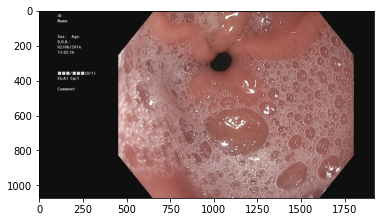

normal-z-line


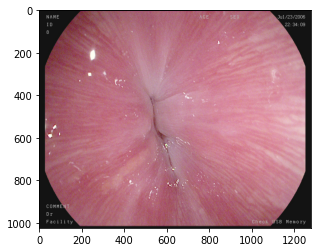

polyps


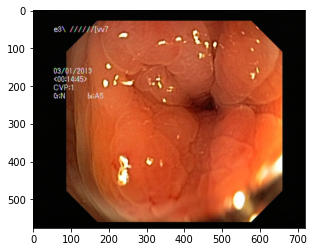

ulcerative-colitis


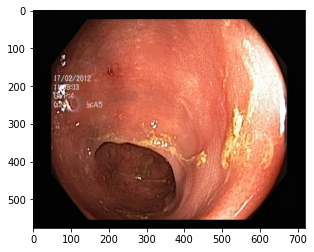

In [11]:
# show an example of each class with image + label
for (i, index) in enumerate(unique_indices):
    path = img_paths[index]
    label = data_labels[index]

    img = cv2.imread(path)
    rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    print("=============")
    print(label)
    plt.imshow(rgb_image)
    plt.show()
    print("=============")

In [12]:
# Transform to numpy arrays
data_raw_pixels = np.array(data_raw_pixels)
data_color_histogram = np.array(data_color_histogram)
data_labels = np.array(data_labels)

In [13]:
print("data_raw_pixels: {:.2f}MB".format(data_raw_pixels.nbytes / (1024 * 1000.0)))
print("data_color_histogram: {:.2f}MB".format(data_color_histogram.nbytes / (1024 * 1000.0)))

data_raw_pixels: 24.00MB
data_color_histogram: 16.00MB


### 2.2 Training

We are making two models: one based on pixel intensities and one based on color histograms. 

The code below creates two train/test splits of our dataset with each of these features.

In [11]:
# Train / Test splitting (100 => 75% train, 25% test)

# pixel intensity features
x_train_raw_pixels, x_test_raw_pixels, y_train_raw_pixels, y_test_raw_pixels = train_test_split(data_raw_pixels, data_labels, test_size=0.25, random_state=42)

# color histogram features
x_train_color_histogram, x_test_color_histogram, y_train_color_histogram, y_test_color_histogram = train_test_split(data_color_histogram, data_labels, test_size=0.25, random_state=42)

#### Grid search
Perform a grid search to find optimal parameters between the supplied options in the search grid

In [ ]:
from sklearn.model_selection import GridSearchCV

# search for the best KNN model with these parameters
grid_params = {
    'n_neighbors': [3, 5, 11, 19],
    'weights': ['uniform','distance'],
    'metric': ['euclidean', 'manhattan']
}

# raw pixels
print("Performing grid search on pixel intensity based features")
gs_rp = GridSearchCV(estimator=KNeighborsClassifier(), cv=3, param_grid=grid_params, verbose = 1, n_jobs = -1)
gs_results_rp = gs_rp.fit(x_train_raw_pixels, y_train_raw_pixels)

# color histogram
print("Performing grid search on color histogram based features")
gs_ch = GridSearchCV(estimator=KNeighborsClassifier(), cv=3, param_grid=grid_params, verbose = 1, n_jobs = -1)
gs_results_ch = gs_ch.fit(x_train_color_histogram, y_train_color_histogram)

Performing grid search on pixel intensity based features
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 28.2min finished


Performing grid search on color histogram based features
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  3.0min finished


In [ ]:
best_params_rp = gs_rp.best_params_ 
best_model_rp = gs_rp.best_estimator_
best_score_rp = gs_rp.best_score_

best_params_ch = gs_ch.best_params_ 
best_model_ch = gs_ch.best_estimator_
best_score_ch = gs_ch.best_score_

In [ ]:
print("Training results")
print(f"Best performing raw pixels model got {best_score_rp*100:.2f}% acc with params: {best_params_rp}")
print(f"Best performing color histogram model got {best_score_ch*100:.2f}% acc with params: {best_params_ch}")

Training results
Best performing raw pixels model got 64.02% acc with params: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Best performing color histogram model got 67.02% acc with params: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}


In [ ]:
# Grid Search results for Raw Pixel feature model:
pd.DataFrame(gs_rp.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
13,2.544077,0.032554,74.200160,0.260340,manhattan,11,distance,"{'metric': 'manhattan', 'n_neighbors': 11, 'we...",0.6420,0.6395,0.6390,0.640167,0.001312,1
7,2.594589,0.015621,63.240058,1.541044,euclidean,19,distance,"{'metric': 'euclidean', 'n_neighbors': 19, 'we...",0.6365,0.6435,0.6390,0.639667,0.002896,2
15,2.551551,0.022670,74.742094,1.039645,manhattan,19,distance,"{'metric': 'manhattan', 'n_neighbors': 19, 'we...",0.6390,0.6380,0.6335,0.636833,0.002392,3
5,2.597260,0.002344,62.312092,1.534487,euclidean,11,distance,"{'metric': 'euclidean', 'n_neighbors': 11, 'we...",0.6300,0.6345,0.6460,0.636833,0.006737,4
4,2.596529,0.047375,62.321743,1.653916,euclidean,11,uniform,"{'metric': 'euclidean', 'n_neighbors': 11, 'we...",0.6270,0.6365,0.6455,0.636333,0.007554,5
12,2.526253,0.015754,74.351858,0.331818,manhattan,11,uniform,"{'metric': 'manhattan', 'n_neighbors': 11, 'we...",0.6375,0.6340,0.6360,0.635833,0.001434,6
6,2.589758,0.029389,63.381824,1.577557,euclidean,19,uniform,"{'metric': 'euclidean', 'n_neighbors': 19, 'we...",0.6360,0.6375,0.6340,0.635833,0.001434,7
11,2.569968,0.053459,72.612305,0.329436,manhattan,5,distance,"{'metric': 'manhattan', 'n_neighbors': 5, 'wei...",0.6380,0.6310,0.6340,0.634333,0.002867,8
14,2.554544,0.008219,75.626287,0.365751,manhattan,19,uniform,"{'metric': 'manhattan', 'n_neighbors': 19, 'we...",0.6405,0.6340,0.6275,0.634000,0.005307,9
3,2.599715,0.013633,61.453233,1.607778,euclidean,5,distance,"{'metric': 'euclidean', 'n_neighbors': 5, 'wei...",0.6295,0.6350,0.6335,0.632667,0.002321,10


In [ ]:
# Grid Search results for Color Histogram feature model:
pd.DataFrame(gs_ch.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
13,0.379775,0.010058,8.568651,0.153316,manhattan,11,distance,"{'metric': 'manhattan', 'n_neighbors': 11, 'we...",0.6660,0.6670,0.6775,0.670167,0.005201,1
15,0.378010,0.006615,9.039115,0.165881,manhattan,19,distance,"{'metric': 'manhattan', 'n_neighbors': 19, 'we...",0.6685,0.6600,0.6765,0.668333,0.006737,2
12,0.379588,0.011406,8.656617,0.112531,manhattan,11,uniform,"{'metric': 'manhattan', 'n_neighbors': 11, 'we...",0.6610,0.6640,0.6730,0.666000,0.005099,3
14,0.391945,0.006139,9.120114,0.152800,manhattan,19,uniform,"{'metric': 'manhattan', 'n_neighbors': 19, 'we...",0.6625,0.6545,0.6750,0.664000,0.008436,4
11,0.386826,0.016497,7.971267,0.111561,manhattan,5,distance,"{'metric': 'manhattan', 'n_neighbors': 5, 'wei...",0.6575,0.6520,0.6805,0.663333,0.012345,5
10,0.372455,0.009597,8.041387,0.116553,manhattan,5,uniform,"{'metric': 'manhattan', 'n_neighbors': 5, 'wei...",0.6600,0.6515,0.6710,0.660833,0.007983,6
9,0.369118,0.002204,7.715083,0.123599,manhattan,3,distance,"{'metric': 'manhattan', 'n_neighbors': 3, 'wei...",0.6475,0.6510,0.6690,0.655833,0.009419,7
8,0.380231,0.004060,7.726374,0.129553,manhattan,3,uniform,"{'metric': 'manhattan', 'n_neighbors': 3, 'wei...",0.6510,0.6495,0.6650,0.655167,0.006980,8
5,0.380559,0.008382,5.914199,0.069052,euclidean,11,distance,"{'metric': 'euclidean', 'n_neighbors': 11, 'we...",0.6450,0.6505,0.6580,0.651167,0.005328,9
7,0.378289,0.004878,6.346813,0.046606,euclidean,19,distance,"{'metric': 'euclidean', 'n_neighbors': 19, 'we...",0.6540,0.6385,0.6600,0.650833,0.009058,10


### 2.3 Testing and evaluation

In this section we evaluate the model against unseen instances of our dataset (our remaining 25%)



In [ ]:
# Make predictions on test data
predictions_rp = best_model_rp.predict(x_test_raw_pixels)
predictions_ch = best_model_ch.predict(x_test_color_histogram)

#### 2.3.1 Evaluate raw pixel model

                        precision    recall  f1-score   support

    dyed-lifted-polyps       0.56      0.23      0.33       260
dyed-resection-margins       0.59      0.59      0.59       246
           esophagitis       0.81      0.56      0.67       254
          normal-cecum       0.57      0.96      0.71       250
        normal-pylorus       0.84      0.88      0.86       245
         normal-z-line       0.58      0.79      0.67       225
                polyps       0.49      0.35      0.41       278
    ulcerative-colitis       0.61      0.71      0.65       242

              accuracy                           0.63      2000
             macro avg       0.63      0.64      0.61      2000
          weighted avg       0.63      0.63      0.61      2000

[[ 61 101   0  37   0   0  48  13]
 [ 47 146   1  24   0   0  18  10]
 [  0   0 143   0   8 103   0   0]
 [  0   0   0 241   0   0   1   8]
 [  0   0   9   0 216  20   0   0]
 [  0   0  22   0  25 178   0   0]
 [  0   0   1  92  

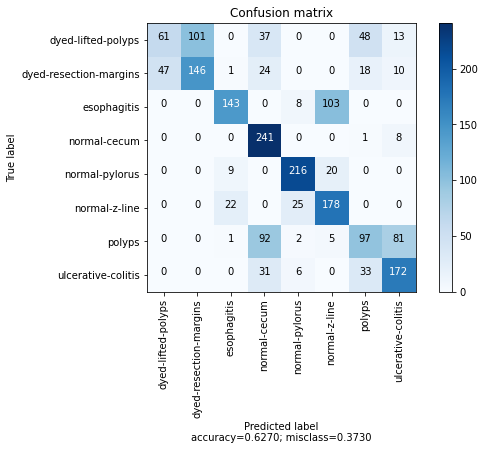

In [ ]:
rp_cm = confusion_matrix(y_test_raw_pixels, predictions_rp)
rp_cr = classification_report(y_test_raw_pixels, predictions_rp, target_names=unique_labels)
print(rp_cr)
print(rp_cm)
plot_confusion_matrix(rp_cm, unique_labels, normalize=False)

#### 2.3.2 Evaluate color histogram model

                        precision    recall  f1-score   support

    dyed-lifted-polyps       0.69      0.55      0.61       260
dyed-resection-margins       0.68      0.66      0.67       246
           esophagitis       0.76      0.57      0.65       254
          normal-cecum       0.62      0.86      0.72       250
        normal-pylorus       0.88      0.96      0.92       245
         normal-z-line       0.60      0.76      0.67       225
                polyps       0.65      0.51      0.57       278
    ulcerative-colitis       0.61      0.62      0.61       242

              accuracy                           0.68      2000
             macro avg       0.69      0.69      0.68      2000
          weighted avg       0.69      0.68      0.68      2000

[[142  77   2  16   0   2  12   9]
 [ 61 163   0  11   0   0   5   6]
 [  0   0 144   0   5 105   0   0]
 [  0   0   0 216   0   0  15  19]
 [  0   0   1   0 234   8   0   2]
 [  0   0  43   0  11 171   0   0]
 [  1   0   0  64  

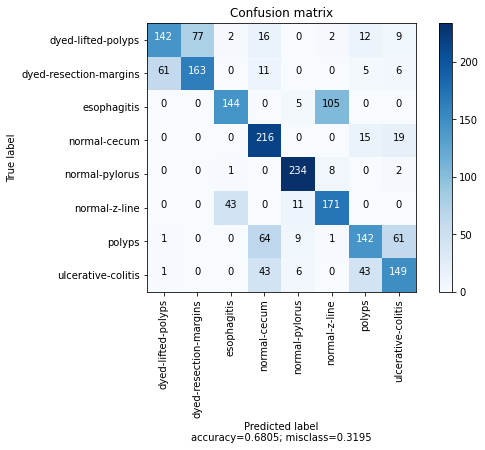

In [ ]:
ch_cm = confusion_matrix(y_test_color_histogram, predictions_ch)
ch_cr = classification_report(y_test_color_histogram, predictions_ch, target_names=unique_labels)
print(ch_cr)
print(ch_cm)
plot_confusion_matrix(ch_cm, unique_labels, normalize=False)

## 3 Convolutional Neural Networks (CNN)

### 3.1 Enable GPU

This part should use GPU for processing. 

The following blocks verify that we are indeed using a GPU / that a GPU has been found by Tensorflow.

In [17]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# Load the TensorBoard notebook extension
%load_ext tensorboard

In [18]:
# Verify we are using GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### 3.1 Preprocessing

In this part we set up our datagenerators, which handle our train/test split as well as our image augmentation and scaling.

In [19]:
path = 'kvasir-dataset-v2'
batch_size = 32
target_w = 256
target_h = 256
target_size = (target_w, target_h) 
target_dims = 3 #(rgb)

datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.25)

train_generator = datagen.flow_from_directory(
    path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='training') # set as training data

test_generator = datagen.flow_from_directory(
    path, 
    target_size=target_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation',
    shuffle=False) # set as validation data

Found 6000 images belonging to 8 classes.
Found 2000 images belonging to 8 classes.


### 3.2 Simple CNN

#### 3.2.1 Build Model

In [ ]:
# Build a simple CNN model layer by layer
# reference: https://www.tensorflow.org/tutorials/images/cnn
def build_simple_cnn():
    model = keras.models.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(target_w, target_h, target_dims)),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu')
    ])

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(8, activation='softmax'))

    model.summary()

    return model

In [ ]:
# Build and compile the model
simple_cnn = build_simple_cnn()

simple_cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=[ 'accuracy' ]
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 230400)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                1

#### 3.2.2 Training

In [ ]:
simple_cnn_best_weights_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='cnn_simple_best.hdf5', verbose=1, save_best_only=True)

# Train (fit) the model
simple_cnn_hist = simple_cnn.fit_generator(train_generator, 
                        epochs=10,
                        verbose=1, 
                        callbacks=simple_cnn_best_weights_checkpoint,
                        validation_data=test_generator)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
188/188 [==============================] - ETA: 0s - loss: 1.0164 - accuracy: 0.5677
Epoch 00001: val_loss improved from inf to 0.80112, saving model to cnn_simple_best.hdf5
188/188 [==============================] - 215s 1s/step - loss: 1.0164 - accuracy: 0.5677 - val_loss: 0.8011 - val_accuracy: 0.6415
Epoch 2/10
188/188 [==============================] - ETA: 0s - loss: 0.7527 - accuracy: 0.6548
Epoch 00002: val_loss improved from 0.80112 to 0.77287, saving model to cnn_simple_best.hdf5
188/188 [==============================] - 210s 1s/step - loss: 0.7527 - accuracy: 0.6548 - val_loss: 0.7729 - val_accuracy: 0.6405
Epoch 3/10
188/188 [==============================] - ETA: 0s - loss: 0.7008 - accuracy: 0.6773
Epoch 00003: val_loss improved from 0.77287 to 0.70836, saving model to cnn_simple_best.hdf5
188/188 [==============================] - 224s 1s/step - loss: 0.7008 - accuracy: 0.6773 - val_l

#### 3.2.3 Testing and evaluation

In [ ]:
# Make predictions
test_generator.reset()
simple_cnn_predictions = simple_cnn.predict_generator(test_generator, verbose=1)

Instructions for updating:
Please use Model.predict, which supports generators.
63/63 [==============================] - 52s 833ms/step


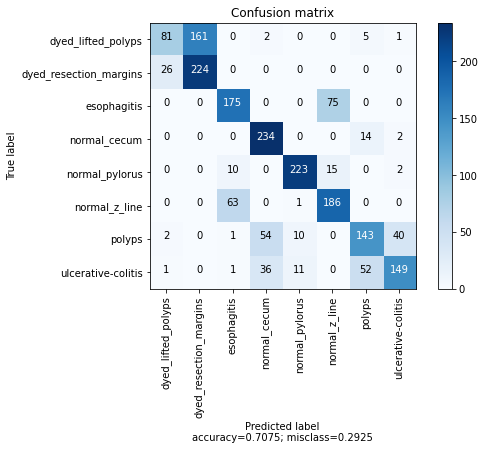

Classification Report
                        precision    recall  f1-score   support

    dyed_lifted_polyps       0.74      0.32      0.45       250
dyed_resection_margins       0.58      0.90      0.71       250
           esophagitis       0.70      0.70      0.70       250
          normal_cecum       0.72      0.94      0.81       250
        normal_pylorus       0.91      0.89      0.90       250
         normal_z_line       0.67      0.74      0.71       250
                polyps       0.67      0.57      0.62       250
    ulcerative-colitis       0.77      0.60      0.67       250

              accuracy                           0.71      2000
             macro avg       0.72      0.71      0.70      2000
          weighted avg       0.72      0.71      0.70      2000

Raw Confusion Matrix
[[ 81 161   0   2   0   0   5   1]
 [ 26 224   0   0   0   0   0   0]
 [  0   0 175   0   0  75   0   0]
 [  0   0   0 234   0   0  14   2]
 [  0   0  10   0 223  15   0   2]
 [  0   0  

In [ ]:
# Create and display confusion matrix and classification report
target_names = ['dyed_lifted_polyps', 'dyed_resection_margins', 'esophagitis', 'normal_cecum', 'normal_pylorus', 'normal_z_line', 'polyps', 'ulcerative-colitis']

y_pred = np.argmax(simple_cnn_predictions, axis=-1)
y_true = test_generator.classes[test_generator.index_array]

conf_matr = confusion_matrix(y_true, y_pred)

plot_confusion_matrix(conf_matr, target_names, normalize=False)

print('Classification Report')
print(classification_report(y_true, y_pred, target_names=target_names))

print('Raw Confusion Matrix')
print(conf_matr)

### 3.3 ResNet50

#### 3.3.1 Build Model

In [ ]:
# Build a CNN model with transfer learning, using ResNet50 as the base model
def build_transfer_learning_model():
  
  # The ResNet
  base_model = keras.applications.resnet.ResNet50(include_top=False, 
                                                  weights='imagenet', 
                                                  input_shape=(target_w, target_h, target_dims))
  
  # We need our BatchNormalization layers to be trainable, the rest should be frozen
  for layer in base_model.layers:
    if isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

  # Put together our model
  model = keras.models.Sequential([
                       base_model,
                       keras.layers.GlobalAveragePooling2D(),
                       keras.layers.Dropout(0.5),
                       keras.layers.Dense(8, activation="softmax")
  ])
  
  model.summary()

  return model

In [ ]:
# Build and compile the model
rn_model = build_transfer_learning_model()

rn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=[ 'accuracy' ]
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 16392     
Total params: 23,604,104
Trainable params: 69,512
Non-trainable params: 23,534,592
_________________________________________________________________


#### 3.3.2 Training

In [ ]:
train_generator.reset()
test_generator.reset()

rn_history = rn_model.fit_generator(train_generator, 
                        epochs=20,
                        verbose=1, 
                        validation_data=test_generator)

Epoch 1/20
188/188 [==============================] - ETA: 0s - loss: 0.7917 - accuracy: 0.6917
Epoch 00001: val_loss improved from inf to 3.27066, saving model to rn_model_best_first.hdf5
188/188 [==============================] - 262s 1s/step - loss: 0.7917 - accuracy: 0.6917 - val_loss: 3.2707 - val_accuracy: 0.1250
Epoch 2/20
188/188 [==============================] - ETA: 0s - loss: 0.4388 - accuracy: 0.8293
Epoch 00002: val_loss did not improve from 3.27066
188/188 [==============================] - 256s 1s/step - loss: 0.4388 - accuracy: 0.8293 - val_loss: 4.3963 - val_accuracy: 0.1250
Epoch 3/20
188/188 [==============================] - ETA: 0s - loss: 0.3561 - accuracy: 0.8598
Epoch 00003: val_loss did not improve from 3.27066
188/188 [==============================] - 254s 1s/step - loss: 0.3561 - accuracy: 0.8598 - val_loss: 4.3579 - val_accuracy: 0.2270
Epoch 4/20
188/188 [==============================] - ETA: 0s - loss: 0.3185 - accuracy: 0.8767
Epoch 00004: val_loss did

#### 3.3.3 Testing and evaluation

In [ ]:
test_generator.reset()
rn_predictions = rn_model.predict_generator(test_generator, verbose=1)

63/63 [==============================] - 53s 835ms/step


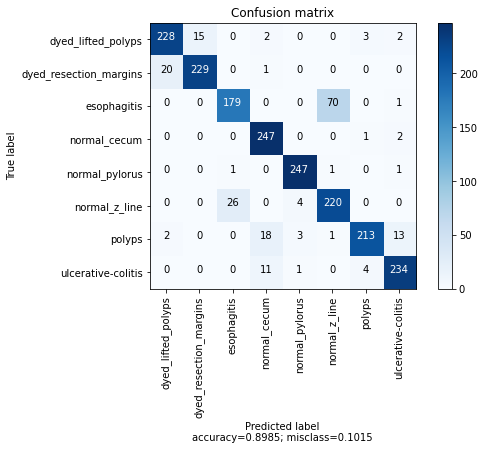

Classification Report
                        precision    recall  f1-score   support

    dyed_lifted_polyps       0.91      0.91      0.91       250
dyed_resection_margins       0.94      0.92      0.93       250
           esophagitis       0.87      0.72      0.79       250
          normal_cecum       0.89      0.99      0.93       250
        normal_pylorus       0.97      0.99      0.98       250
         normal_z_line       0.75      0.88      0.81       250
                polyps       0.96      0.85      0.90       250
    ulcerative-colitis       0.92      0.94      0.93       250

              accuracy                           0.90      2000
             macro avg       0.90      0.90      0.90      2000
          weighted avg       0.90      0.90      0.90      2000

Raw Confusion Matrix
[[228  15   0   2   0   0   3   2]
 [ 20 229   0   1   0   0   0   0]
 [  0   0 179   0   0  70   0   1]
 [  0   0   0 247   0   0   1   2]
 [  0   0   1   0 247   1   0   1]
 [  0   0  

In [ ]:
#####
# ResNet 1st iteration
#####
# Create and display confusion matrix and classification report
target_names = ['dyed_lifted_polyps', 'dyed_resection_margins', 'esophagitis', 'normal_cecum', 'normal_pylorus', 'normal_z_line', 'polyps', 'ulcerative-colitis']

y_pred = np.argmax(rn_predictions, axis=-1)
y_true = test_generator.classes[test_generator.index_array]

conf_matr = confusion_matrix(y_true, y_pred)

plot_confusion_matrix(conf_matr, target_names, normalize=False)

print('Classification Report')
print(classification_report(y_true, y_pred, target_names=target_names))

print('Raw Confusion Matrix')
print(conf_matr)

#### 3.3.4 Unfreeze and fine-tune

In [ ]:
rn_model.trainable = True

rn_model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss='sparse_categorical_crossentropy',
    metrics=[ 'accuracy' ],
)

best_weights_checkpoint_2 = tf.keras.callbacks.ModelCheckpoint(filepath='rn_model_best_second.hdf5', verbose=1, save_best_only=True)

train_generator.reset()
test_generator.reset()
rn_history_2 = rn_model.fit_generator(train_generator, 
                        epochs=10,
                        verbose=1, 
                        callbacks=best_weights_checkpoint_2,
                        validation_data=test_generator)

Epoch 1/10
188/188 [==============================] - ETA: 0s - loss: 0.1337 - accuracy: 0.9462
Epoch 00001: val_loss improved from inf to 0.27660, saving model to rn_model_best_second.hdf5
188/188 [==============================] - 269s 1s/step - loss: 0.1337 - accuracy: 0.9462 - val_loss: 0.2766 - val_accuracy: 0.9055
Epoch 2/10
188/188 [==============================] - ETA: 0s - loss: 0.1231 - accuracy: 0.9523
Epoch 00002: val_loss did not improve from 0.27660
188/188 [==============================] - 262s 1s/step - loss: 0.1231 - accuracy: 0.9523 - val_loss: 0.2967 - val_accuracy: 0.9025
Epoch 3/10
188/188 [==============================] - ETA: 0s - loss: 0.1108 - accuracy: 0.9580
Epoch 00003: val_loss improved from 0.27660 to 0.27145, saving model to rn_model_best_second.hdf5
188/188 [==============================] - 259s 1s/step - loss: 0.1108 - accuracy: 0.9580 - val_loss: 0.2714 - val_accuracy: 0.9145
Epoch 4/10
188/188 [==============================] - ETA: 0s - loss: 0.0

KeyboardInterrupt: ignored

#### 3.3.5 Testing and evaluation

63/63 [==============================] - 55s 875ms/step


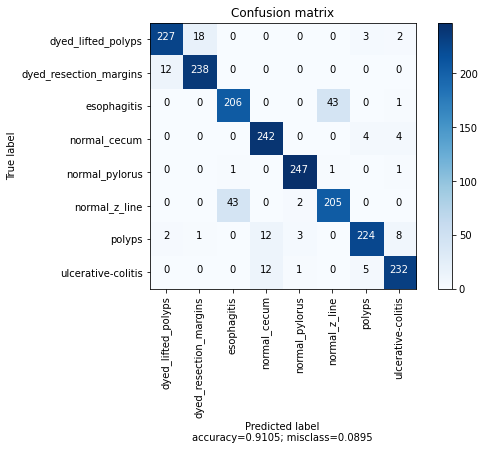

Classification Report
                        precision    recall  f1-score   support

    dyed_lifted_polyps       0.94      0.91      0.92       250
dyed_resection_margins       0.93      0.95      0.94       250
           esophagitis       0.82      0.82      0.82       250
          normal_cecum       0.91      0.97      0.94       250
        normal_pylorus       0.98      0.99      0.98       250
         normal_z_line       0.82      0.82      0.82       250
                polyps       0.95      0.90      0.92       250
    ulcerative-colitis       0.94      0.93      0.93       250

              accuracy                           0.91      2000
             macro avg       0.91      0.91      0.91      2000
          weighted avg       0.91      0.91      0.91      2000

Raw Confusion Matrix
[[227  18   0   0   0   0   3   2]
 [ 12 238   0   0   0   0   0   0]
 [  0   0 206   0   0  43   0   1]
 [  0   0   0 242   0   0   4   4]
 [  0   0   1   0 247   1   0   1]
 [  0   0  

In [ ]:
#####
# Resnet fine-tuned
#####
test_generator.reset()
rn_predictions = rn_model.predict_generator(test_generator, verbose=1)

# Create and display confusion matrix and classification report
target_names = ['dyed_lifted_polyps', 'dyed_resection_margins', 'esophagitis', 'normal_cecum', 'normal_pylorus', 'normal_z_line', 'polyps', 'ulcerative-colitis']

y_pred = np.argmax(rn_predictions, axis=-1)
y_true = test_generator.classes[test_generator.index_array]

conf_matr = confusion_matrix(y_true, y_pred)

plot_confusion_matrix(conf_matr, target_names, normalize=False)

print('Classification Report')
print(classification_report(y_true, y_pred, target_names=target_names))

print('Raw Confusion Matrix')
print(conf_matr)

## 4 Other

In [ ]:
"""
DISPLAY INCORRECTLY CLASSIFIED
"""

# reverse k, v => v, k
class_indices = {v: k for k, v in test_generator.class_indices.items()}

for i in range(0,2000):
    filepath = test_generator.filepaths[i]
    filename = test_generator.filenames[i]
    label_index = test_generator.classes[i]
    prediction = np.argmax(rn_predictions, axis=-1)[i]

    true_label = class_indices[label_index]
    pred_label = class_indices[prediction]

    if label_index != prediction:
        plt.figure(figsize=(8,6))
        plt.axis("off")
        plt.title(f"true: {true_label} / pred: {pred_label}")
        plt.imshow(cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB))
        # plt.savefig(f"/content/gdrive/My Drive/TDT4173/incorrect-{i}.png")
        plt.show()
    else:
        if i % 20 == 0:
            plt.figure(figsize=(8,6))
            plt.axis("off")
            plt.title(f"true: {true_label} / pred: {pred_label}")
            plt.imshow(cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB))
            # plt.savefig(f"/content/gdrive/My Drive/TDT4173/correct-{i}.png")
            plt.show()
